## Practice on Applying RNN/LSTM model on imdb sentiment analysis

In [22]:
import warnings
warnings.simplefilter('ignore')

#import necessary modules
import numpy as np
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical

# Set random seed
np.random.seed(0)

### Overvies of the dataset

In [3]:
# Set the number of features we want
#num_words: integer or None. Top most frequent words to consider. 
#Any less frequent word will appear as oov_char value in the sequence data.
number_of_features = None

# Load data and target vector from movie review data
(train_data, train_target), (test_data, test_target) = imdb.load_data(num_words=number_of_features)

In [4]:
train_data.shape, test_data.shape, train_target.shape, test_target.shape

((25000,), (25000,), (25000,), (25000,))

In [5]:
#The longest comment in training set
max([len(train_data[i]) for i in range(len(train_data))])

2494

In [6]:
#get the word_index_dict
word_index_dict = imdb.get_word_index()

1646592/1641221 [==============================] - 3s 2us/step


In [7]:
len(word_index_dict)

88584

In [13]:
#create index_word_dict
index_word_dict = dict()
for k,v in word_index_dict.items():
    index_word_dict[v] = k
len(index_word_dict)

88584

In [14]:
#let's see what the comment is
def get_comment(dataset, index):
    comment = []
    for w in dataset[index]:
        comment.append(index_word_dict[w])
    return ' '.join(comment)

In [15]:
get_comment(train_data, 1)

"the thought solid thought senator do making to is spot nomination assumed while he of jack in where picked as getting on was did hands fact characters to always life thrillers not as me can't in at are br of sure your way of little it strongly random to view of love it so principles of guy it used producer of where it of here icon film of outside to don't all unique some like of direction it if out her imagination below keep of queen he diverse to makes this stretch stefan of solid it thought begins br senator machinations budget worthwhile though ok brokedown awaiting for ever better were lugia diverse for budget look kicked any to of making it out bosworth's follows for effects show to show cast this family us scenes more it severe making senator to levant's finds tv tend to of emerged these thing wants but fuher an beckinsale cult as it is video do you david see scenery it in few those are of ship for with of wild to one is very work dark they don't do dvd with those them"

In [19]:
#categorical_labels = to_categorical(train_target, num_classes=None)
#categorical_labels.shape # only 2 categories(0/1)
#del(categorical_labels)
train_target[1]

0

The dataset is very small if we want to apply deep learning RNN model on it. And the size of the training set is the same as the test set, both are 25,000. Although it is a small dataset, the longest comment has more than 2 thousand words, and the comments includes 88,584 unique words, which might make the RNN model hard to converge. 

### EDA

Since the length of each comment is different, I would like to limit the length and make every comment have the same length. To decide which maxlen I should pick, I would like to do some digging to see the features of the dataset.

In [26]:
def get_comment_length(dataset):
    length_list = np.array([len(i) for i in dataset])
    return length_list

In [32]:
train_length_data = get_comment_length(train_data)
print('Std: ', train_length_data.std())
print('Mean: ', train_length_data.mean()) 
print('Median: ', np.percentile(train_length_data, 50))

Std:  176.49367364852034
Mean:  238.71364
Median:  178.0


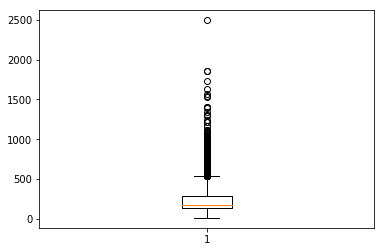

In [35]:
#import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.boxplot(train_length_data)
plt.show()

In [36]:
train_up_limit = np.percentile(train_length_data, 75) + 1.5*(np.percentile(train_length_data, 75) - 
                                                             np.percentile(train_length_data, 25))
train_up_limit #about 93% 
#np.percentile(train_length_data, 93) #538.0
#np.percentile(train_length_data, 99) #926.0

532.5

In [50]:
#count word usage
from collections import defaultdict
def word_counter(dataset):
    wc = defaultdict(int)
    for i in range(len(dataset)):
        for j in dataset[i]:
            wc[j] += 1
    return wc
len(word_counter(train_data))

88585

In [48]:
def usage_calculate(wc):
    above_100 = []
    above_500 = []
    above_1000 = []
    for k,v in wc.items():
        if v >= 1000:
            above_1000.append(k)
        elif v >= 500:
            above_500.append(k)
        elif v >= 100:
            above_100.append(k)
    return above_1000, above_500, above_100
        
above_1000, above_500, above_100 = usage_calculate(word_counter(train_data))
print('More than 1000 counts: ', len(above_1000))
print('More than 500 counts: ', len(above_1000)+len(above_500))
print('More than 100 counts: ', len(above_1000)+len(above_500)+len(above_100))

More than 1000 counts:  612
More than 500 counts:  1157
More than 100 counts:  4311


After some digging, I find that the length of comments is diverse. Although the shortest comment has only 11 words, the median and standard deviation are 178 and 176.5 respectively. Also, only 4311 words are counted more than 100 times while there are total 88,585 words used in commenting.

### First and fast try

In [57]:
# Use words which have more than 500 counts 
number_of_features = 1157

# Load data and target vector from movie review data
(train_data, train_target), (test_data, test_target) = imdb.load_data(num_words=number_of_features)

In [58]:
#reduce the word using
len(word_counter(train_data))

1155

In [63]:
# Use padding or truncation to make each observation have 532 features (up outlier limit)
train_features = sequence.pad_sequences(train_data, maxlen=532)
test_features = sequence.pad_sequences(test_data, maxlen=532)
len(test_features[0])

532

In [65]:
def lstm_model(number_of_features, output_dims = 128, units_num = 128):
    # Start neural network
    network = models.Sequential()

    # Add an embedding layer
    network.add(layers.Embedding(input_dim=number_of_features, output_dim=output_dims))

    # Add a long short-term memory layer with 128 units
    network.add(layers.LSTM(units=units_num))

    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation='sigmoid'))
    
    # Compile neural network
    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer='Adam',     # Adam optimization
                    metrics=['accuracy']) # Accuracy performance metric
    return network

In [66]:
network = lstm_model(number_of_features, output_dims = 128, units_num = 128)

In [67]:
network.fit(train_features, train_target,
           epochs = 5,
           verbose=1,               # Get the progressing bar in each epoch
           batch_size=256,          # Number of observations per batch
           validation_data=(test_features, test_target)) # Data for evaluation

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 784s 31ms/step - loss: 0.6068 - acc: 0.6617 - val_loss: 0.4618 - val_acc: 0.7843
Epoch 2/5
25000/25000 [==============================] - 800s 32ms/step - loss: 0.4429 - acc: 0.8194 - val_loss: 0.4045 - val_acc: 0.8255
Epoch 3/5
25000/25000 [==============================] - 3941s 158ms/step - loss: 0.3568 - acc: 0.8526 - val_loss: 0.3391 - val_acc: 0.8588
Epoch 4/5
25000/25000 [==============================] - 733s 29ms/step - loss: 0.3382 - acc: 0.8589 - val_loss: 0.3415 - val_acc: 0.8554
Epoch 5/5
25000/25000 [==============================] - 945s 38ms/step - loss: 0.3056 - acc: 0.8744 - val_loss: 0.3141 - val_acc: 0.8676


Reference:

https://chrisalbon.com/deep_learning/keras/lstm_recurrent_neural_network/

https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

https://medium.com/@thoszymkowiak/how-to-implement-sentiment-analysis-using-word-embedding-and-convolutional-neural-networks-on-keras-163197aef623